# Chapter 6

# Linear Model Selection and Regularization

Some ways in which linear model can be improved by replacing least squares fitting with some alternative fitting procedures. These alternative procedures will improve the prediction accuracy and model interpretibility.

__1. Prediction Accuracy__ :- Least square method is supposed to have low bias if the true model is linear and also if data is big enough it will have low variance as well. But if:

    (i). p > n, no least square solution exist.
    (ii). if n is not much larger than p, estimates will have higher variability and the model might overfit.
   By constraining ot shrinkage, we can reduce the variance with some negligible increase in bias.

__2. Model Interpretibility__ :- By setting irrelevant variables to zero, we can increase interpretibility of the model. Least square is unlikely to do that.


## 3 methods of model selection and regularization :-
__1. Best Subset Selection__:- Identifying a subset of p predictors that we believe related to response.

__2. Shrinkage__:- Fitting a model with all variables but they are shrunken towards zero relative to least squares. Shrinkage can also perform variable selection.

__3. Dimension Reduction__:- Projecting p predictors into M dimensional subspace, where M < p. This is done by taking M linear combination of the p variables.

## Subset Selection :-
Methods of selecting subset of predictors.

### 1. Best Subset Selection :-
Fit a seperate regression model for each combination of p predictors. Several stages of Best subset selection.
1. Start with $M_o$ i.e. a null model.
2. For k = 1,2,...p, Fit all $p \choose k$ models and pick the best among them and call them $M_0$ based on RSS or $R^2$.
3. Select a single best model from $M_0, M_1,......,M_p$ using cross validated prediction error, $C_p$, AIC, BIC or adjusted $R^2$.

Step 2 is reducing the problem from one of $2^p$ to one of (p+1) possible models. But as p increases, RSS decreases and $R^2$ increase so we will end up selecting model with maximum variable. We need to check performance of test data and hence come step 3.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
import random
import itertools
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from IPython.display import Image
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression

In [2]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Credit.csv"
Credit = pd.read_csv(url, index_col = 0)
variables = Credit.columns
variables = variables.drop("Balance")

In [17]:
results = []
for k in range(len(variables)):
    for subset in itertools.combinations(variables,k+1):
        all_columns = "+".join(list(subset))
        my_formula = "Balance~" + all_columns
        model = ols(formula = my_formula, data = Credit).fit()
        results.append({"RSS":model.mse_resid, "R_squared": model.rsquared,"Variable_count": k+1, 
                        'resid_sum': (model.resid ** 2).sum(), 'BIC': model.bic, 
                        'Adjusted_R2': model.rsquared_adj})
    print("Done for : ",k)
RSS_and_r2 = pd.DataFrame(results)
Min_RSS = RSS_and_r2.groupby(["Variable_count"])['RSS'].min().reset_index()
Max_R2 = RSS_and_r2.groupby(["Variable_count"])['R_squared'].max().reset_index()
Min_BIC = RSS_and_r2.groupby(["Variable_count"])['BIC'].min().reset_index()
Max_adj_R2 = RSS_and_r2.groupby(["Variable_count"])['Adjusted_R2'].max().reset_index()

Done for :  0
Done for :  1
Done for :  2
Done for :  3
Done for :  4
Done for :  5
Done for :  6
Done for :  7
Done for :  8
Done for :  9


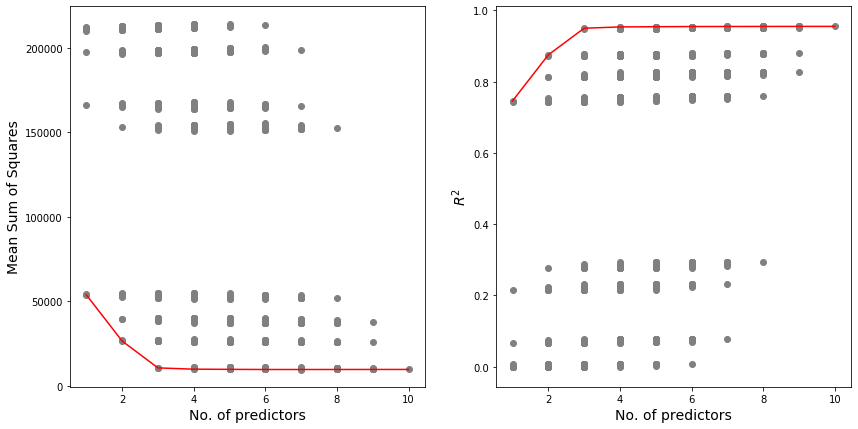

In [79]:
fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(RSS_and_r2["Variable_count"], RSS_and_r2["RSS"], color = "grey")
ax1.plot(Min_RSS["Variable_count"], Min_RSS["RSS"], color = "r")
ax1.set_xlabel("No. of predictors", fontsize = 14)
ax1.set_ylabel("Mean Sum of Squares", fontsize = 14)
ax2 = fig.add_subplot(122)
ax2.scatter(RSS_and_r2["Variable_count"], RSS_and_r2["R_squared"], color = "grey")
ax2.plot(Max_R2["Variable_count"], Max_R2["R_squared"], color = "r")
ax2.set_xlabel("No. of predictors", fontsize = 14)
ax2.set_ylabel("$R^2$", fontsize = 14)
plt.show()

Above plot shows that, after adding 3 variables, there is little improvement in RSS and $R^2$ with each additional variable. So the subset of 3 variable with combination that gives minimum error can be used for model building.

For classification, instead of RSS or $R^2$, we can use deviance.

__Deviance__:- Negetive two times the maximized log-likelihood; smaller the deviance, better the fit. Deviance can be used for a broader class of models. 

__Drawbacks of Best Subset Selection__ :-
1. The drawback is that it can be computationally expensive if p is large.
2. When p is large, we have a big search space and hence more chances of selecting a model that is good at training but not on testing.

### 2. Stepwise Selection :-
Selecting a far more restricted set of variables.

__Forward Stepwise Selection__ :- 
1. Start with null model $M_o$.
2. For k = 0,1,2,.....,p-1. 
    
    (i). Consider all p-k models that augment the predictors in $M_k$ with one additional predictor.
    
    (ii). Choose the best among p-k models and call it $M_{k+1}$. Here best is defined as having smallest RSS or highest $R^2$.
    
3. Select a single model from $M_0, M_1, .... , M_p$ using cross validation error, $C_p$, AIC, BIC, etc.

Unlike Best subset selection, now we are considering only, 1 + p(p+1)/2 models.

__Drawbacks__:- 
1. Not guaranteed to find the best model.
2. If best one variable models has $X_1$, but best 2 variable model contain $X_2, X_3$, then forward selection will never select that model because 2 variable model will always have $X_1$.

__Advantage__:- Forward selection can be applied in high dimensional setting where n < p; however we can only construct $M_1,......,M_{n-1}$ only.

__Backward Stepwise Selection__ :- 
1. Start with null model $M_o$.
2. For k = p,p-1,....,1.
    
    (i). Consider all k models that contains all but one of the predictors in $M_k$ for a total of k-1 predictors
    
    (ii). Choose the best among these k models and call it $M_{k-1}$. Here best is defined as having smallest RSS or highest $R^2$.
    
3. Select a single model from $M_0, M_1, .... , M_p$ using cross validation error, $C_p$, AIC, BIC, etc.

Backward and Forward selection both have similar advantage and disadvantages. Both do not guarantee best subset and also do not give identical model.

__Hybrid Approach__:- To closely mimic best subset selection, we need to remove variable as well at each stage while adding.

### Choosing the best model 
In the above mentioned methods, in order to select the best model with respect to test error:
1. We can indirectly estimate test error by making an adjustment to the training error to account for the bias due to overfitting.
2. Estimate test error, using a validation set approach.

__$C_p$, AIC, BIC and adjusted $R^2$__ :-
To select between model with different no. of parameters, we can't use training RSS and training $R^2$ as they decrease with each adding variable even if that variable do not add any value.

But there are techniques to adjust training error for the model size available. Such as :-
1. __$C_p$__:- For fitted least squares model containing d predictors, the $C_p$ estimate of test MSE is 
$$C_p = \frac{1}{n}(RSS + 2d \hat\sigma^2)$$
where $\hat\sigma^2$ = estimate of variance of the error $\epsilon$. $\hat\sigma^2$ is estimated using full model containing all p predictors.

$C_p$ is adding a penalty of 2d$\hat\sigma^2$ to the training RSS in order to adjust for the fact that training error underestimates test error. As d increase, penalty increase.

$C_p$ is unbiased estimate of test error. Lower the $C_p$, better the model.

2. __AIC (Akaike Information Criteria)__ :- Defined for a large class of model fit by maximum likelihood. For least squares,
$$AIC = \frac{1}{n\hat\sigma^2} (RSS + 2d \hat\sigma^2).$$
For least squares, $C_p$ and AIC are proportional to each other.

3. __BIC (Bayesian Information Criteria)__ :- For least squares with p predictors,
$$BIC = \frac{1}{n\hat\sigma^2} (RSS + log(n)d \hat\sigma^2)$$

BIC replaces $2d \hat\sigma^2$ with $log(n)d \hat\sigma^2$, where n is no. of observations. For any n > 7, log(n) > 2, the BIC statistic generally places a heavier penalty on models with many variables, and hence result in models with less predictors.

4. __Adjusted $R^2$__ :- Since RSS always decrease as more variables are added to the model, the $R^2$ always increase.
$$Adj. R^2 = \frac{1 - RSS/(n-d-1)}{TSS/(n-1)}$$
Large Adj. $R^2$, better model.
Now as no. of variable increases, RSS/(n-d-1), may or may not increase due to the presence of d in denominator.
Adjusting $R^2$ prevents us to use noise variable.

In [61]:
# We will calculate Cp for Credit data.
sigma_sq = RSS_and_r2[RSS_and_r2['Variable_count']== 10]['resid_sum']/(len(Credit) - (len(variables)+1) -1)
RSS_and_r2["Cp"] = (RSS_and_r2['resid_sum'] + 2 * RSS_and_r2['Variable_count'] * sigma_sq.values)/len(Credit)
Min_Cp = RSS_and_r2.groupby(["Variable_count"])['Cp'].min().reset_index()

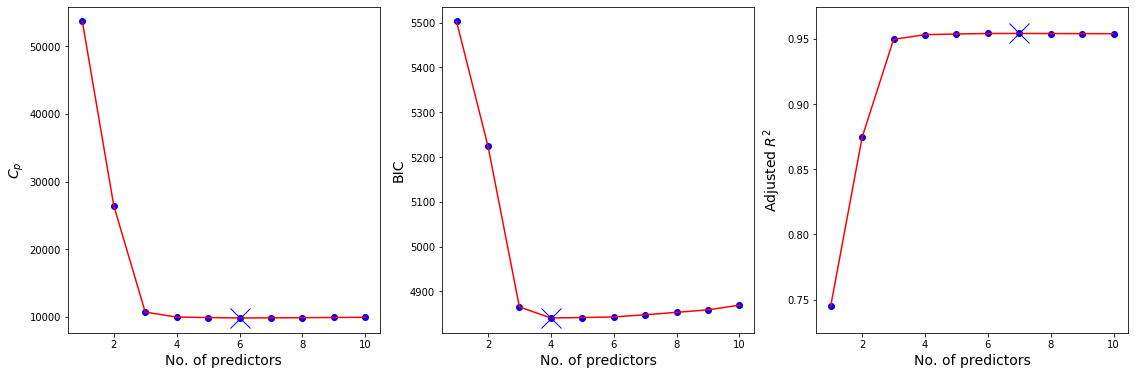

In [71]:
fig = plt.figure(figsize = (19,6))
ax1 = fig.add_subplot(131)
ax1.scatter(Min_Cp["Variable_count"], Min_Cp["Cp"], color = "b")
ax1.plot(Min_Cp["Variable_count"], Min_Cp["Cp"], color = "r")
ax1.plot(Min_Cp["Cp"].idxmin() + 1, Min_Cp["Cp"].min(), marker = "x", markersize = 20, color = 'b')
ax1.set_xlabel("No. of predictors", fontsize = 14)
ax1.set_ylabel("$C_p$", fontsize = 14)

ax2 = fig.add_subplot(132)
ax2.scatter(Min_BIC["Variable_count"], Min_BIC["BIC"], color = "b")
ax2.plot(Min_BIC["Variable_count"], Min_BIC["BIC"], color = "r")
ax2.plot(Min_BIC["BIC"].idxmin() + 1, Min_BIC["BIC"].min(), marker = "x", markersize = 20, color = 'b')
ax2.set_xlabel("No. of predictors", fontsize = 14)
ax2.set_ylabel("BIC", fontsize = 14)

ax3 = fig.add_subplot(133)
ax3.scatter(Max_adj_R2["Variable_count"], Max_adj_R2["Adjusted_R2"], color = "b")
ax3.plot(Max_adj_R2["Variable_count"], Max_adj_R2["Adjusted_R2"], color = "r")
ax3.plot(Max_adj_R2["Adjusted_R2"].idxmax() + 1, Max_adj_R2["Adjusted_R2"].max(), marker = "x", markersize = 20, color = 'b')
ax3.set_xlabel("No. of predictors", fontsize = 14)
ax3.set_ylabel("Adjusted $R^2$", fontsize = 14)

plt.show()

The above plot shows that all the 3 measure of model performance has a minimum value for different set of predictors (marked as blue). But the inspection of above plots also shows that all of them suggest that after 3 variable, improvement was not significant for each additional variable. So all of them will ultimately get us to select the same model.

__Validation and cross validation__

As an alternate to above methods, we can directly estimate test error using validation test and cross validation methods. If we have a lot of data, CV methods are always preferred.

* Also, validation approach make lesser assumptions about the true underlying methods.
* Validation set approach depends on how we split the data and would probably result in different selection of models. AIC, BIC, etc do not have that problem.

__One standard error rule__ :-
1. Calculate estimate of test error for each model size.
2. Select the model with smallest predictor set for which estimated test error is within one S.E. of lowest point on the curve. If a lot of model give similar estimate of test error, choose the simplest model.

## Shrinkage Methods 
We can fit a model with all the predictors but some of them are shrinked towards zero. Such a method can significantly reduce the variance of the model.

### Ridge Regression 
Ridge regression coefficient estimates $\beta^R$ are values that minimizes 
$$\sum_{i = 1}^{n}(y_i - \beta_0 - \sum_{j = 1}^{p}\beta_jx_{ij})^2 + \lambda \sum_{j = 1}^{p}\beta_{j}^{2} = RSS + \lambda \sum_{j = 1}^{p}\beta_{j}^{2}$$

where $\lambda \ge 0$ is a tuning parameter, to be determined seperately.

$\lambda \sum_{j = 1}^{p}\beta_{j}^{2}$ called shrinkage penalty. As we are minimizing it, so it has the effect of shrinking the estimates towards zero.

* For $\lambda = 0$, no effect of penalty.
* $\lambda -> \infty$, shrinkage penalty grows and coefficients approaches zero.
* Note that shrinkage do not apply to the intercept.
* Also, befor performing ridge we should scale the variable because in least squares multiplying the variable by a number results in scaling of coefficients as well and $X_j\beta_j$ remain same but not in ridge.

$X_j\beta_j^R$ not only depends on $\lambda$ but also on scaling of predictors(also on the scaling of other predictors).

$$x_{ij}^R = \frac{x_{ij}}{\sqrt{\frac{1}{n} \sum_{i = 1}^{n}(x_{ij} - \bar x_j)^2}}$$

In [2]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Credit.csv"
Credit = pd.read_csv(url, index_col = 0)
dummy = pd.get_dummies(Credit[['Gender','Student','Married','Ethnicity']]) # Creating dummies for categorical vars
Credit = pd.concat([Credit,dummy],axis = 1)
Credit.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance', 'Gender_ Male',
       'Gender_Female', 'Student_No', 'Student_Yes', 'Married_No',
       'Married_Yes', 'Ethnicity_African American', 'Ethnicity_Asian',
       'Ethnicity_Caucasian'],
      dtype='object')

In [165]:
# Code for fitting ridge regression model for different values of lambda.
X = np.array(Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1))
y = np.array(Credit['Balance'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
lambda_range = 10**np.linspace(-2,5,100)
coef = []
for l in lambda_range:
    model = Ridge(alpha = l)
    model.fit(X,y)
    coef.append(list(model.coef_))
coef_df = pd.DataFrame(coef,columns = Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1).columns)
del coef

In [7]:
# Fitting a linear regression with out regularization
lm = LinearRegression()
lm.fit(X,y)
l2_norm_lm = np.sqrt(sum(map(lambda i: i*i,lm.coef_))) # l2 norm for linear regression
# l2 norm for Ridge regression coefficient corresponding to each lambda
coef_df_arr = np.array(coef_df)
l2_norm_ridge = [np.sqrt(sum(map(lambda i: i*i,beta))) for beta in coef_df_arr]
l2_norm_ratio = [i/l2_norm_lm for i in l2_norm_ridge]

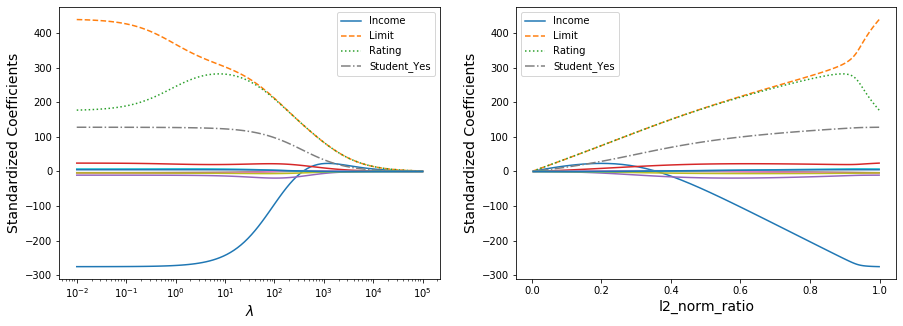

In [200]:
fig = plt.figure(figsize = (15,5))
# Plotting coefficients corresponding to lambdas
ax1 = fig.add_subplot(121)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax1.plot(lambda_range, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax1.plot(lambda_range, coef_df[col],linestyle = linestyles[i])    
ax1.set_xscale('log')
ax1.set_xlabel("$\lambda$", fontsize = 14)
ax1.set_ylabel("Standardized Coefficients", fontsize = 14)
ax1.legend()

# Plotting coefficients corresponding to l2 norm ratio of ridge rigression and linear regression.
ax2 = fig.add_subplot(122)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax2.plot(l2_norm_ratio, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax2.plot(l2_norm_ratio, coef_df[col], linestyle = linestyles[i])    
ax2.set_xlabel("l2_norm_ratio", fontsize = 14)
ax2.set_ylabel("Standardized Coefficients", fontsize = 14)
ax2.legend()
plt.show()

Above plot shows how with increasing value of $\lambda$, coefficients are converging towards zero. Also, increasing not necessarily decrease all the coefficients, as can be seen with Rating varaible. Some individial coefficients might increase as well. 2nd plot, x axis is $|| \hat \beta_{\lambda}^{R}||_2 / || \hat \beta ||_2$ which represents how much ridge regression coefficients have shrunken towards zero.

__Why ridge regression improves over least squares?__

As $\lambda$ increases, the flexibility decrease leading to decreased variance but increased bias. Assume we have a lot predictors p, and $\lambda$ = 0, i.e. least square model will have a very low bias (because we are including all the variables) but very high variance because of overfitting.

As $\lambda$ increases, coefficients shrink towards zero and hence flexibility decrease and hence variance starts decreasing but bias won't get affected much. After a certain value, bias will start increasing as some coefficient approach zero.

This just means that choosing the right value of $\lambda$ will result in improved fit.

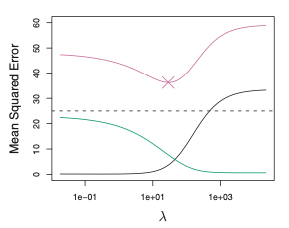

In [1]:
# An image from the book 
Image(filename = "/Users/ankittyagi/Desktop/ISLR Notes and codes/ISLR_Notes_codes/Ridge regression Bias and variance.png")

The above plot shows that bias (black) won't get affected in the beginning but keep on increasing once the variable approach towards zero. And variance (green) will keep on decreasing in the start but stabilize after a certain set of variable becomes close to zero and we are left with less no. of variables in the model.

* When the relationship is linear between response and predictors, least squares will give low bias but may have high variance.
* When p ~ n, least squares will be extremely variable.
* When p > n, ridge can still perform but least square can't. Hence ridge works better when least square have high variance.

__Advantage__ :-

1. Computationally faster than Best subset selection methods.
2. For large p, feasible to use.

__Disadvantage__ :-

1. Include all p variables in the model, even if some of them are not important.
2. If p is large, ridge regression results in very less model interpretibility.

### Lasso Regression
Lasso coefficients $\beta_{\lambda}^{L}$, minimize 
$$\sum_{i = 1}^{n}(y_i - \beta_0 - \sum_{j = 1}^{p}\beta_jx_{ij})^2 + \lambda \sum_{j = 1}^{p}| \beta_{j} | = RSS + \lambda \sum_{j = 1}^{p}| \beta_{j} |$$
where $\sum_{j = 1}^{p}| \beta_{j} |$ is called the l1 penalty. L1 penalty has effect of forcing some coefficients towards zero, hence can perform variable selection.
Depending on value of $\lambda$, lasso can select a model with any no. of variables.

In [24]:
# Code for fitting ridge regression model for different values of lambda.
X = np.array(Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1))
y = np.array(Credit['Balance'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
lambda_range = np.linspace(1,1000, 500)
coef = []
for l in lambda_range:
    model = Lasso(alpha = l)
    model.fit(X,y)
    coef.append(list(model.coef_))
coef_df = pd.DataFrame(coef,columns = Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1).columns)
del coef

In [25]:
# Fitting a linear regression with out regularization
lm = LinearRegression()
lm.fit(X,y)
l2_norm_lm = np.sqrt(sum(map(lambda i: i*i,lm.coef_))) # l2 norm for linear regression
# l2 norm for Ridge regression coefficient corresponding to each lambda
coef_df_arr = np.array(coef_df)
l2_norm_lasso = [np.sqrt(sum(map(lambda i: i*i,beta))) for beta in coef_df_arr]
l2_norm_ratio = [i/l2_norm_lm for i in l2_norm_lasso]

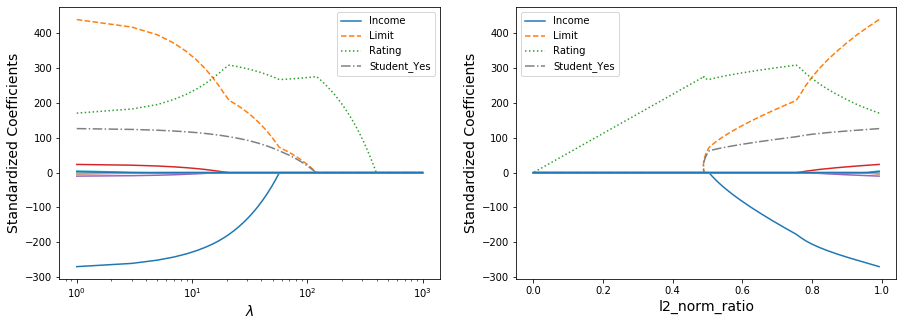

In [26]:
fig = plt.figure(figsize = (15,5))
# Plotting coefficients corresponding to lambdas
ax1 = fig.add_subplot(121)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax1.plot(lambda_range, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax1.plot(lambda_range, coef_df[col],linestyle = linestyles[i])    
ax1.set_xscale('log')
ax1.set_xlabel("$\lambda$", fontsize = 14)
ax1.set_ylabel("Standardized Coefficients", fontsize = 14)
ax1.legend()

# Plotting coefficients corresponding to l2 norm ratio of ridge rigression and linear regression.
ax2 = fig.add_subplot(122)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax2.plot(l2_norm_ratio, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax2.plot(l2_norm_ratio, coef_df[col], linestyle = linestyles[i])    
ax2.set_xlabel("l2_norm_ratio", fontsize = 14)
ax2.set_ylabel("Standardized Coefficients", fontsize = 14)
ax2.legend()
plt.show()

As can be seen in plot above that as the value of $\lambda$ becomes sufficiently large, lasso gives a null model. Also, it can be seen that lasso coefficients converges to zero much quicker than ridge. 

The second plot shows that till a certain value of l2 norm ratio, we just have one variable, then 2-3 varibles added followed by the rest of them. This shows that depending on value of $\lambda$, lasso can produce a model with any no. of variables.

Overall,

Lasso
$$minimize{\sum_{i = 1}^{n}(y_i - \beta_0 - \sum_{j = 1}^{n}\beta_j x_{ij})^2}\ \ subject\ to \sum_{j = 1}^{p}|\beta_j| \le s$$

And ridge,
$$minimize{\sum_{i = 1}^{n}(y_i - \beta_0 - \sum_{j = 1}^{n}\beta_j x_{ij})^2}\ \ subject\ to \sum_{j = 1}^{p}\beta_j^2 \le s$$

This shows a connection between Lasso, ridge and best subset selection. Consider,
$$minimize{\sum_{i = 1}^{n}(y_i - \beta_0 - \sum_{j = 1}^{n}\beta_j x_{ij})^2}\ \ subject\ to \sum_{j = 1}^{p}I(\beta_j \ne 0) \le s$$
Here, $I(\beta_j \ne 0)$ is an indicator. If $\beta_j = 0$, then 0 otherwise 1.
So, minimize RSS subject to constraint that no more than s variable can be zero. This is equivalent to Best Subset selection. But if p is high, Best subset selection is infeasible.

__Variable selection property of Lasso__

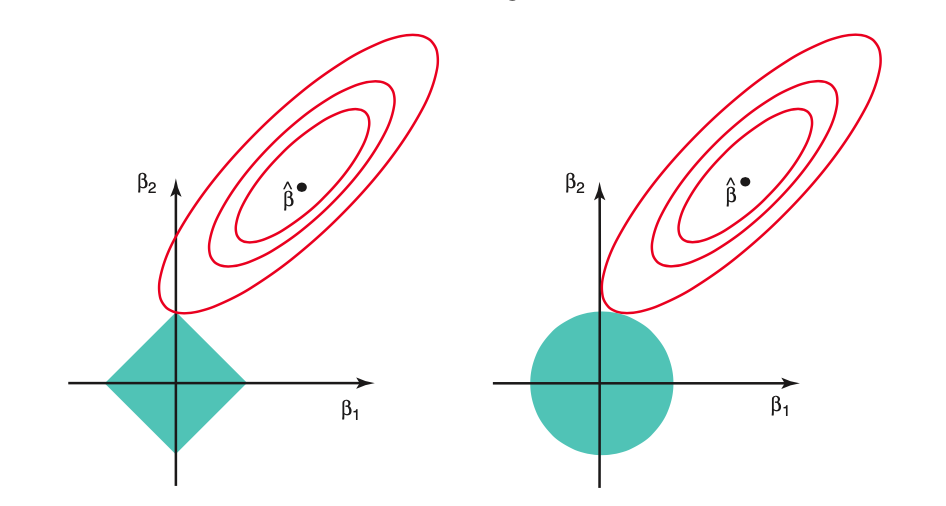

In [28]:
Image(filename = "/Users/ankittyagi/Desktop/ISLR Notes and codes/ISLR_Notes_codes/Ridge and lasso Var selection.png")

In the image above, the least square solution is $\hat \beta$. And the red ellipses are the regions of constant RSS. The green area represents the constraint (left is lasoo and right is ridge). 

Now if s is large, the constraint region will contain $\hat \beta$ and ridge, lasso will be same as least square estimate. Otherwise, the point where the ellipse of error meet the constraint region will be the lasso/ridge estimates of $\beta_1$ and $\beta_2$.

Since ridge regression constraints is circular with no sharp points, this intersection will not generally happen on axis and so the estimate won't be zero. Lasso has corners at each axis so ellipse will often intersect at axis and hence will be zero. The above image is for p = 2 predictors but the same idea applies to more than 2 predictors.

__Comparing Lasso and Ridge regression :-__

1. Lasso can help in variable selection.
2. Lasso might result in high variance becasue it might delete some variable that are in actual model but usually the effect is negligible.
3. Difference in lasso and ridge depends on true form of the model.
4. Lasso outperforms ridge if the relatively small no. of predictors have substantial coefficients and vice versa.
5. Ridge regression more or less shrinks every dimension of the data by same proportion but lasso more or less shrinks all coefficients towards zero by similar amount.

__Bayesian Interpretation of Ridge and lasso__

$\beta$(coeff. vector) has a prior distribution $p(\beta)$.
$$f(Y|X,\beta) = likelihood\ of\ data.$$
Posterior distribution of $p(\beta|X,Y) \propto f(Y|X,\beta) p(\beta|X) = f(Y|X,\beta) p(\beta)$

let $p(\beta) = \prod_{j = 1}^{p}g(\beta_j)$, for some density g. 

1. If g is Guassian distribution with mean 0 and S.D. $\lambda$, then posterior model for $\beta$ i.e. the most likely value for $\beta$ is given by ridge regression coefficients.
2. If g is double exponential distribution with mean 0 and scale parameter $\lambda$, then posterior model for $\beta$ is given by lasso regression coefficients.

__Selecting the tuning parameter__:- Cross validation provide simple way to decide which value of $\lambda$ is better. We choose a grid of $\lambda$ values and calculate the CV error for each $\lambda$ and choose $\lambda$ that results in minimum CV error.

In [62]:
# Code for fitting ridge regression model for different values of lambda.
X = np.array(Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1))
y = np.array(Credit['Balance'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
lambda_range = 50**np.linspace(-2,0.5,100)
ridge_cv = RidgeCV(alphas = lambda_range,store_cv_values=True).fit(X,y)
cv_error = np.mean(ridge_cv.cv_values_, axis = 0)/len(Credit)
coef = []
for l in lambda_range:
    model = Ridge(alpha = l)
    model.fit(X,y)
    coef.append(list(model.coef_))
coef_df = pd.DataFrame(coef,columns = Credit.drop(['Balance','Gender','Student','Married','Ethnicity',
                          'Gender_ Male','Student_No','Married_No','Ethnicity_African American'], axis = 1).columns)
del coef

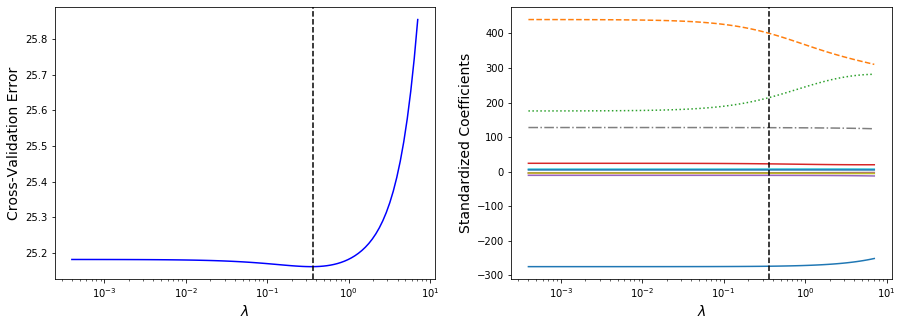

In [65]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax1.set_xscale('log')
ax1.plot(lambda_range, cv_error, color = "b")
ax1.axvline(x = ridge_cv.alpha_, linestyle = "--", color = "black")
ax1.set_xlabel("$\lambda$", fontsize = 14)
ax1.set_ylabel("Cross-Validation Error", fontsize = 14)

ax2 = fig.add_subplot(122)
linestyles = ['-', '--', ':', '-','-','-','-','-.','-','-','-']
for i,col in enumerate(coef_df.columns):
    if col in ['Income','Limit','Rating','Student_Yes'] :
        ax2.plot(lambda_range, coef_df[col], label = col, linestyle = linestyles[i])
    else:
        ax2.plot(lambda_range, coef_df[col],linestyle = linestyles[i])    
ax2.set_xscale('log')
ax2.set_xlabel("$\lambda$", fontsize = 14)
ax2.set_ylabel("Standardized Coefficients", fontsize = 14)
ax2.axvline(x = ridge_cv.alpha_, linestyle = "--", color = "black")
plt.show()

The above plot shows the CV error for a series of $\lambda$ values and the black dotted line shows the value that selected by cross validation. The right plot shows the coefficients across the values of $\lambda$. The dip in error is not that significant, so we might want to select least square estimation only.

## Dimension Reduction Methods
We transform the predictors and then fit a model using transformed variables as predictors. Let $Z_1, Z_2, .... ,Z_M$, M < p are linear combination of our original p predictors.
$$Z_m = \sum_{j = 1}^{p}\phi_{jm}X_j$$
for some constraints $\phi_{1m}, \phi_{2m}, ....... , \phi_{pm}$, m = 1,2,....,M. Then our model becomes
$$y_i = \theta_0 + \sum_{m = 1}\theta_mZ_{im} + \epsilon_i,\ \ i = 1,....,n$$
Dimension reduction approaches can outperform least square estimates. as it helps in reducing the variance of the model. 

Our problem reduced from estimating p coefficients to M coefficients. 
$$\sum_{m = 1}^{M}\theta_m Z_{im} = \sum_{m = 1}^{M}\theta_m \sum_{j = 1}^{p}\phi_{jm}x_{ij} = \sum_{j = 1}^{p} \sum_{m = 1}^{M}\theta_m \phi_{jm} x_{ij} = \sum_{j = 1}^{p}\beta_jx_{ij}$$
$$\beta_j = \sum_{m = 1}^{M}\theta_m\phi_{jm}$$
Hence, it is like a special case of original linear regression model with constraints that $\beta_j = \sum_{m = 1}^{M}\theta_m\phi_{jm}$

### Principal Compenent Analysis (PCA) :-
A technique to reduce he dimension of a n X p data matrix X.
* First principal component direction of the data is that along which the observations vary the most. Also, the projected observations would have the largest possible variance.
* To project a point on the line simply involves finding the location on the line which is closest to the point.
$$Z_1 = \phi_{11}(x - \bar x) + \phi_{21}(y - \bar y)$$
where $\phi_{11}, \phi_{21}$ are the principal component loadings.
* The idea is to find a linear combination of x & y such that $\phi_{11}^2 +  \phi_{21}^2 = 1$, and this particular linear combination should have the highest variance.
* If $\phi_{11} = \phi_{21}$, then $Z_1$ is simply the average of 2 variables.
* First component vector is the line that is as close as possible to the data.
* $Z_{11}, Z_{21}, ...... ,Z_{n1}$ are called the principal component scores.
* A negetive component indicates that the point is below average in one or more feature.
* A positive component indicates that the point is above average in one or more feature.
* How well a component represent 2 vectors is depends on how linearly related two vectors are.

__2nd Principal Component__ :- A linear combination of variables that is uncorrelated with $Z_1$ and has largest variance subject to this constraint. Now, 2nd principal component should be orthogonal to first PC to be uncorrelated. For p predictors, we can create atmost p principal component.

In [84]:
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Carseats.csv"
Carseats = pd.read_csv(url)
X = np.array(Carseats[['Population','Advertising']])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

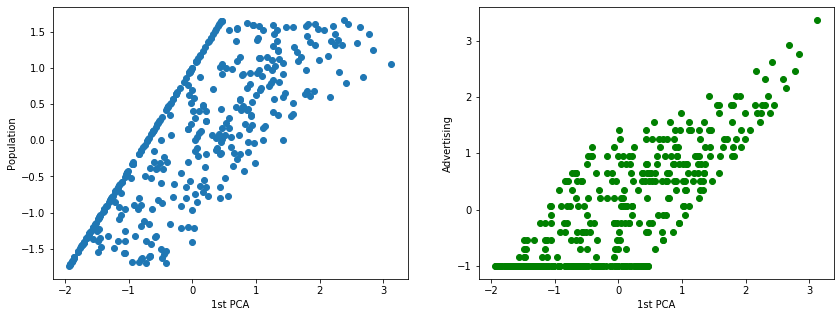

In [105]:
pca = PCA(n_components = 1)
pca.fit(X)
pcs = pca.transform(X)
fig = plt.figure(figsize = (14,5))
ax1 = fig.add_subplot(121)
ax1.scatter(pcs, X[:,0])
ax1.set_xlabel("1st PCA")
ax1.set_ylabel("Population")
ax2 = fig.add_subplot(122)
ax2.scatter(pcs, X[:,1], color = "g")
ax2.set_xlabel("1st PCA")
ax2.set_ylabel("Advertising")
plt.show()

The above plot shows the scatter plot of first component PCA and the variables used to create that.

### Principal Component Regression Approach
While using principal as regression variables, we assume that the directions in which $X_1, X_2, .... , X_p$ show the most variation are the directions that are associated with Y.

If this assumption holds, then fitting a model on principal component $Z_1, Z_2, .... , Z_n$ leads to better result that modeling on $X_1, ... , X_n$. It reduce overfitting. If the true model has less no. of variables, PCR might out perform shrinkage methods as well.

* For a limited dataset, as M increase, bias decrease but variance increase.
* PCR ends up in M $\le$ p predictors but it is not feature selection methods, because we are using all the p features.
* PCR and ridge regression are closely related. Ridge is a continous version of PCR. 
* In PCR, M is choosen using cross validation.
* We need to make sure that all variables are standardized before PCA otherwise high scale or variance variables will play a larger role in PC obtained.

__Drawback of PCA__ :- The $Z_1, Z_2, .... , Z_n$ are identified in unsupervised way with an assumption that they are related to response variable in same way, which might not be true.

### Partial Least Squares 
PLS tries to find linear combination of $X_1, ... , X_n$ that explains response as well as predictors.

__How to calculate__ :-
1. Standardize p predictors.
2. Assign weight to each predictors equal to the coefficients that comes from regression Y on $X_i$ or the correlation coefficient of Y and $X_i$. 
$$\phi_{ji} = \beta_j\ \ (from\ model\ Y = \beta_j X)$$
So we are putting highest weight to variable which is most correlated with response.
3. To identify 2nd PLS direction, we adjust all variables for $Z_1$ i.e. we regress all variable on $Z_1$ and then calculate the residual. This will give us unexplained variation in each variable. 
4. Then $Z_2$ is calculated as linear combination of all these p residuals same as earlier, and so on....

Value M decided from CV. In practice, ridge and PCR might perform similar. PLS can reduce bias but can also increase variance.

### High Dimensional Data
* Traditional techniques of classification and regression will not work in high dimensional setting i.e. $p\ge n$.
* Least squares shouldn't be used if $p \ge n$. For p = n, least squares will give the perfect fit on training set and hence will overfit.
* Same logic applies to logistic regression and linear discriminant analysis.
* Adjusting the training set RSS or $R^2$ in order to account for number of variables using $C_p$, AIC, BIC do not work in high dimensional setting as $\sigma^2$ almost becomes zero.
* Similarly, adjusted $R^2$ also becomes almost equal to $R^2$ as n = p and one can obtain a model with adjusted $R^2$.

* In high dimensional settings, stepwise, PCA, shrinkage methods proves quite useful. These methods protects from overfitted models.
* Regularization plays an important role in high dimensional problems.
* Appropriate tuning parameters selection is crucial.
* Test error tends to increase as dimension increase unless the additional features are truly associated with the response.
* Adding feature that truly associated with response will improve fit.
* Even if feature is relevant, the variance incurred in fitting their coefficients may outweigh the reduction in bias that they bring. Having a test dataset is crucial.

## Lab : Subset Selection Methods
__1. Best Subset Selection__

In [2]:
# Loading Hitters data
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Hitters.csv"
Hitters = pd.read_csv(url)
# checking for the null values in the data.
Hitters["Salary"].isna().sum()

59

In [3]:
#Omit values that have NA
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [4]:
Hitters["Salary"].isna().sum()

0

In [5]:
def Best_subset_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    results = []
    for k in range(len(variables)):
        for subset in itertools.combinations(variables,k+1):
            all_columns = "+".join(list(subset))
            
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            results.append({"RSS":model.mse_resid, "R_squared": model.rsquared,"Variable_count": k+1, 
                            'resid_sum': (model.resid ** 2).sum(), 'BIC': model.bic, 
                            'Adjusted_R2': model.rsquared_adj})
        print("Done for : ",k)
    Matrices = pd.DataFrame(results)
    return(Matrices)
Metrices = Best_subset_selection(Hitters, "Salary")

Done for :  0
Done for :  1
Done for :  2
Done for :  3
Done for :  4
Done for :  5
Done for :  6
Done for :  7
Done for :  8
Done for :  9
Done for :  10
Done for :  11
Done for :  12
Done for :  13
Done for :  14
Done for :  15
Done for :  16
Done for :  17
Done for :  18


In [31]:
sigma_sq = Metrices[Metrices['Variable_count']== len(Hitters.columns) -1]['resid_sum']/(len(Hitters) - len(Hitters.columns) -1)
Metrices["Cp"] = (Metrices['resid_sum'] + 2 * Metrices['Variable_count'] * sigma_sq.values)/len(Hitters)

# Function to calculate the different statistics corresponding to each subset of varibles.
def BSS_metrices(matrix, data):    
    Min_RSS = matrix.groupby(["Variable_count"])['RSS'].min().reset_index()
    Max_R2 = matrix.groupby(["Variable_count"])['R_squared'].max().reset_index()
    Min_BIC = matrix.groupby(["Variable_count"])['BIC'].min().reset_index()
    Max_adj_R2 = matrix.groupby(["Variable_count"])['Adjusted_R2'].max().reset_index()
    sigma_sq = matrix[matrix['Variable_count']== len(data.columns) -1]['resid_sum']/(len(data) - len(data.columns) -1)
    Min_Cp = matrix.groupby(["Variable_count"])['Cp'].min().reset_index()
    All_mat = pd.concat([Min_RSS, Max_R2["R_squared"], Min_BIC["BIC"], Max_adj_R2["Adjusted_R2"], Min_Cp["Cp"]], axis = 1)
    return(All_mat)

Eval_mat = BSS_metrices(Metrices,Hitters)

In [82]:
Eval_mat

,Variable_count,RSS,R_squared,BIC,Adjusted_R2,Cp
0,1,138619.460747,0.321450,3869.283615,0.318850,138325.798618
1,2,117871.384194,0.425224,3831.203767,0.420802,118047.800202
2,3,112931.648092,0.451429,3824.503056,0.445075,113495.491255
3,4,108414.154325,0.475407,3818.321064,0.467273,109394.961755
4,5,105641.632031,0.490804,3816.058548,0.480897,107033.948057
5,6,102323.843467,0.508715,3812.213078,0.497200,104163.264700
6,7,101594.303924,0.514123,3814.874046,0.500785,103827.330687
7,8,98964.291098,0.528557,3812.514735,0.513708,101661.506427
8,9,98079.254492,0.534612,3814.686826,0.518057,101194.309579
9,10,97223.815626,0.540495,3816.913469,0.522261,100762.202859


In [84]:
# Function to get the list of variables that resulted in best statistics defined.
def get_best_param(Eval_mat, matrix, stats, dataset, response):
    variables = dataset.columns
    variables = variables.drop(response)
    if stats in ['RSS','BIC','Cp']:        
        no_var = (Eval_mat[Eval_mat[stats] == Eval_mat[stats].min()]["Variable_count"]).values[0]
        min_val = Eval_mat[stats].min()
        data = matrix[matrix['Variable_count'] == no_var]
        print(list(itertools.combinations(variables,no_var))[data[data[stats] == min_val].index[0] - data.index[0]])
    else:    
        no_var = (Eval_mat[Eval_mat[stats] == Eval_mat[stats].max()]["Variable_count"]).values[0]
        max_val = Eval_mat[stats].max()
        data = matrix[matrix['Variable_count'] == no_var]
        print(list(itertools.combinations(variables,no_var))[data[data[stats] == max_val].index[0] - data.index[0]])
        
get_best_param(Eval_mat, Metrices, 'BIC', Hitters, 'Salary')

('AtBat', 'Hits', 'Walks', 'CRBI', 'Division', 'PutOuts')


The above list of variables result in the minimum BIC. We can evaluate that for any statistic.

__2. Forward Selection__

In [217]:
# This function will return the best model with lowest BIC using Forward Selection method
def Forward_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    forward_sel = []
    var_left = variables.copy()
    BIC = []
    
    for k in range(len(variables)):
        RSS = []
        metric = []
        
        for p in range(len(var_left)):
            subset = forward_sel + [var_left[p]]
            all_columns = "+".join(subset)
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            RSS.append(model.mse_resid)
            metric.append(model.bic)
            
        forward_sel.append(var_left[RSS.index(min(RSS))])
        BIC.append(metric[RSS.index(min(RSS))])
            
        var_left = [x for x in variables if x not in forward_sel]
        print('Done for ', k)
        
    final_selection = forward_sel[:BIC.index(min(BIC))+1] # model with lowest BIC
    
    # Model for the final selection
    all_col = "+".join(final_selection)
    my_formula = response + '~' + all_col
    model = ols(formula = my_formula, data = dataset).fit()

    return model

FS_model = Forward_selection(Hitters,'Salary')

Done for  0
Done for  1
Done for  2
Done for  3
Done for  4
Done for  5
Done for  6
Done for  7
Done for  8
Done for  9
Done for  10
Done for  11
Done for  12
Done for  13
Done for  14
Done for  15
Done for  16
Done for  17
Done for  18


In [218]:
# The model selected from the forward selection model is:-
FS_model.params

Intercept         91.511798
Division[T.W]   -122.951534
CRBI               0.643017
Hits               7.604398
PutOuts            0.264308
AtBat             -1.868589
Walks              3.697647
dtype: float64

__3. Backward Selection__

In [266]:
# This function will return the best model with lowest BIC using Backward Selection method
def Backward_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    backward_sel = []
    var_left = variables.copy()
    BIC = []
    
    for k in range(len(variables)):
        RSS = []
        metric = []
        if k == 0:
            subset = var_left
            all_columns = "+".join(subset)
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            
            backward_sel.append(var_left)
            BIC.append(model.bic)
        
        else:
            for p in range(len(var_left)):
                subset = [var_left[i] for i in range(len(var_left)) if i!= p]
                all_columns = "+".join(subset)
                my_formula = response + '~' + all_columns
                model = ols(formula = my_formula, data = dataset).fit()
                RSS.append(model.mse_resid)
                metric.append(model.bic)
            
            backward_sel.append([var_left[i] for i in range(len(var_left)) if i!= RSS.index(min(RSS))])
            BIC.append(metric[RSS.index(min(RSS))])
            
            var_left = np.delete(var_left, RSS.index(min(RSS)))
        
        print('Done for ', k)
        
    final_selection = backward_sel[BIC.index(min(BIC))] # model with lowest BIC
    
    # Model for the final selection
    all_col = "+".join(final_selection)
    my_formula = response + '~' + all_col
    model = ols(formula = my_formula, data = dataset).fit()

    return model

BS_model = Backward_selection(Hitters,'Salary')

Done for  0
Done for  1
Done for  2
Done for  3
Done for  4
Done for  5
Done for  6
Done for  7
Done for  8
Done for  9
Done for  10
Done for  11
Done for  12
Done for  13
Done for  14
Done for  15
Done for  16
Done for  17
Done for  18


In [268]:
BS_model.params

Intercept        117.152043
Division[T.W]   -123.779837
AtBat             -2.033921
Hits               6.854914
Walks              6.440664
CRuns              0.704539
CRBI               0.527324
CWalks            -0.806606
PutOuts            0.275389
dtype: float64

We can see that forward and backward selection leads to different selection of model. Now in the above 2 approaches we have used BIC to select among the models. 
 
## Lab 2: Ridge Regression and Lasso

__Ridge Regression__

In [64]:
# Loading Hitters data
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Hitters.csv"
Hitters = pd.read_csv(url)
Hitters = Hitters.dropna()

dummy = pd.get_dummies(Hitters[['League','Division','NewLeague']]) # Creating dummies for categorical vars
Hitters = pd.concat([Hitters,dummy],axis = 1)
# Code for fitting ridge regression model for different values of lambda.
X = np.array(Hitters.drop(['Salary','League','Division','NewLeague','League_A',
                          'Division_E','NewLeague_A'], axis = 1))
y = np.array(Hitters['Salary'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
lambda_range = 10**np.linspace(10,-2,100)
coef = []
for l in lambda_range:
    model = Ridge(alpha = l)
    model.fit(X,y)
    coef.append(list(model.coef_))
col = Hitters.drop(['Salary','League','Division','NewLeague','League_A','Division_E','NewLeague_A'], axis = 1).columns
coef_df = pd.DataFrame(coef,columns = col, index = lambda_range)
del coef

In [65]:
coef_df.shape

(100, 19)

In [66]:
coef_df.index[49] # to get the 50th index

11497.569953977356

In [71]:
coef_df.iloc[49,] # Coefficient for lambda = 11497.569953977356

AtBat          3.494574
Hits           3.952735
HmRun          2.983900
Runs           3.754690
RBI            3.981076
Walks          3.991857
Years          3.461209
CAtBat         4.617142
CHits          4.848250
CHmRun         4.625988
CRuns          4.969938
CRBI           5.008957
CWalks         4.275527
PutOuts        2.837986
Assists        0.236442
Errors        -0.069616
League_N      -0.034223
Division_W    -1.877802
NewLeague_N    0.048489
Name: 11497.569953977356, dtype: float64

In [75]:
np.sqrt((coef_df.iloc[49,]**2).sum())

15.509329901628673

In [76]:
coef_df.index[59] # to get the 60th index

705.4802310718645

In [77]:
coef_df.iloc[59,] # Coefficient for lambda = 705.4802310718645

AtBat          16.436909
Hits           24.147890
HmRun          11.541520
Runs           20.796881
RBI            19.997243
Walks          23.885453
Years          13.478743
CAtBat         22.482103
CHits          25.850293
CHmRun         23.990950
CRuns          26.454467
CRBI           26.819732
CWalks         18.862008
PutOuts        24.649574
Assists         1.677569
Errors         -2.602909
League_N        4.294669
Division_W    -19.598632
NewLeague_N     3.190716
Name: 705.4802310718645, dtype: float64

In [79]:
np.sqrt((coef_df.iloc[59,]**2).sum()) # l2 norm

84.41074083895579

In [113]:
# Dividing the data in train and test
lambda_range = np.linspace(1,500,500)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=70)
cv_ridge = RidgeCV(alphas = lambda_range).fit(X_train,y_train)
cv_ridge.alpha_ 
# The value of lambda will change based on the random split of the data.

122.0

In [114]:
# Calculating the MSE on the test data set.
ridge_predict = cv_ridge.predict(X_test)
((ridge_predict - y_test) ** 2).mean()

101745.10126424646

__Lasso Regression__

In [119]:
## Lasso Regression 
lambda_range = np.linspace(1,1000,100)
coef = []
for l in lambda_range:
    model = Lasso(alpha = l)
    model.fit(X,y)
    coef.append(list(model.coef_))
col = Hitters.drop(['Salary','League','Division','NewLeague','League_A','Division_E','NewLeague_A'], axis = 1).columns
coef_df = pd.DataFrame(coef,columns = col, index = lambda_range)
del coef

Similar to ridge, LassoCV can help us in identifying the value of $\lambda$ for which error is minimum.

In [125]:
cv_Lasso = LassoCV().fit(X_train,y_train)
Lasso_predict = cv_Lasso.predict(X_test)
((Lasso_predict - y_test) ** 2).mean()

/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4458.029246231541, tolerance: 2115.8083984058994
  tol, rng, random, positive)
/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6655.831660654396, tolerance: 2115.8083984058994
  tol, rng, random, positive)
/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7089.927342426032, tolerance: 2115.8083984058994
  tol, rng, random, positive)
/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: C

100680.46115150684

In [126]:
cv_Lasso.coef_

array([  0.        ,  79.03854298,  -0.        ,   0.        ,
         0.        ,  15.71341079,   0.        ,   0.        ,
        39.63770893,   0.        ,   0.        , 161.6793307 ,
         0.        ,  58.16239304,  21.91091686,  -0.        ,
         0.        , -53.76668353,   0.        ])

We can see that in Lasso a lot coefficient has converged to zero.

## Lab 3: PCR and PLS Regression
__Principal Component Regression__

In [10]:
# Loading Hitters data
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Hitters.csv"
Hitters = pd.read_csv(url)
Hitters = Hitters.dropna()

dummy = pd.get_dummies(Hitters[['League','Division','NewLeague']]) # Creating dummies for categorical vars
Hitters = pd.concat([Hitters,dummy],axis = 1)

X = np.array(Hitters.drop(['Salary','League','Division','NewLeague','League_A',
                          'Division_E','NewLeague_A'], axis = 1))
y = np.array(Hitters['Salary'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Fitting PCA
pca = PCA(n_components = 19)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=19, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [40]:
# How much variance is explained by each compoenent.
pca.explained_variance_ratio_

array([3.83142396e-01, 2.18410758e-01, 1.06863592e-01, 8.19251975e-02,
       5.25608081e-02, 4.34450422e-02, 3.62810828e-02, 2.70015556e-02,
       1.31964802e-02, 9.72721749e-03, 7.22341252e-03, 6.70946072e-03,
       5.03086617e-03, 3.21246472e-03, 2.73557843e-03, 1.47396692e-03,
       7.41715623e-04, 2.55915858e-04, 6.24891919e-05])

The Python don't have a PCA cross validation function, so we have to code it.

In [23]:
# Get a list of models to evaluate
mse = make_scorer(mean_squared_error)

def get_models():
    models = dict()
    for i in range(1,20):
        steps = [('pca',PCA(n_components = i)),('m',LinearRegression())]
        models[str(i)] = Pipeline(steps = steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
    scores = cross_val_score(model, X, y, scoring= mse, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    

>1 121369.299 (47132.870)
>2 122581.860 (69195.720)
>3 124059.099 (69387.224)
>4 123199.242 (91331.429)
>5 123690.074 (59827.899)
>6 119877.200 (56066.912)
>7 117451.409 (61096.617)
>8 117979.184 (66005.564)
>9 122390.575 (73349.697)
>10 120649.569 (68724.591)
>11 120530.173 (59023.515)
>12 125275.268 (83550.663)
>13 123103.712 (75314.078)
>14 117480.839 (65114.187)
>15 125833.622 (67782.594)
>16 124351.700 (71290.374)
>17 114256.317 (69331.957)
>18 115640.006 (53347.900)
>19 117928.920 (60621.479)


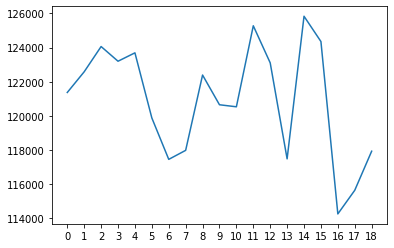

In [38]:
plt.plot(np.mean(results, axis = 1))
plt.xticks(list(range(0,19)))
plt.show()

As can be seen from the plot that cross validation error is smallest when components are 17. But as we have seen that the variance explained is also very small after 10 components, a smaller n_components can be used.

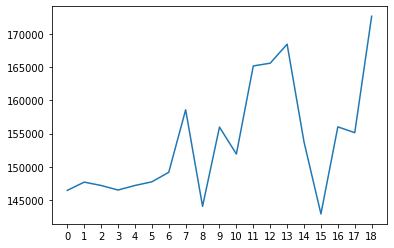

In [41]:
# Now we will fit the PCR on the training data and calculate the error 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=70)
def get_models():
    models = dict()
    for i in range(1,20):
        steps = [('pca',PCA(n_components = i)),('m',LinearRegression())]
        models[str(i)] = Pipeline(steps = steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
    scores = cross_val_score(model, X_train, y_train, scoring= mse, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
plt.plot(np.mean(results, axis = 1))
plt.xticks(list(range(0,19)))
plt.show()

This time it looks like the number of components are just 9. Now we will calculate the error on the test dataset.

In [66]:
# fit the PCA and transform the training and test dataset
X_train_PCA = models['8']['pca'].fit_transform(X_train)
X_test_PCA = models['8']['pca'].transform(X_test)

lm = LinearRegression()
lm.fit(X_train_PCA, y_train)
np.mean((lm.predict(X_test_PCA) - y_test)**2)

98787.91999183677

The error is slightly smaller than the error we got from Lasso regression model. However the result of PCA are interpretable as it is not producing the coefficients.

__Partial Least Squares__

In [96]:
pls = PLSRegression(n_components = 19)
pls.fit(X,y)

# PLS don't tell the variance explained by each component. We will try to code it.
total_variance_in_x = np.var(X, axis = 0)
variance_in_x = np.var(pls.x_scores_, axis = 0) 

# normalize variance by total variance:
fractions_of_explained_variance = variance_in_x / total_variance_in_x

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [88]:
fractions_of_explained_variance

array([7.08453802e+00, 1.57924882e+00, 2.21689945e+00, 8.17558140e-01,
       3.72287945e-01, 8.33867208e-01, 3.87746060e-01, 2.59360777e-01,
       3.81923337e-01, 1.56091147e-01, 2.26561932e-01, 1.47734031e-01,
       5.71263639e-02, 3.37017063e-02, 6.94639402e-02, 1.77637393e-02,
       7.55416943e-02, 5.34116543e-02, 1.19781451e-03])

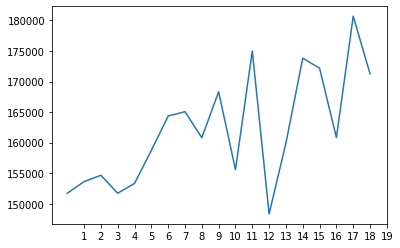

In [104]:
# evaluate a given model using cross-validation
def PLS_cv(X,y,n_comp):
    model = PLSRegression(n_components = n_comp)
    cv = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
    scores = cross_val_score(model, X, y, scoring= mse, cv=cv, n_jobs=-1)
    return scores

# evaluate the models and store results
results, names = list(), list()
for i in range(1,20):
    scores = PLS_cv(X_train,y_train,i)
    results.append(scores)
    names.append(i)    
    
plt.plot(np.mean(results, axis = 1))
plt.xticks(names)
plt.show()

The lowest cross validation error is when n_components is 13.

In [127]:
# fit the PCA and transform the training and test dataset
pls = PLSRegression(n_components =13)

X_train_PLS = pls.fit_transform(X_train, y_train)
X_train_PLS = X_train_PLS[0]

X_test_PLS = pls.transform(X_test)

lm = LinearRegression()
lm.fit(X_train_PLS, y_train)
np.mean((lm.predict(X_test_PLS) - y_test)**2)

101354.29853637319

The MSE is comparable but slightly higher than the one we got from ridge, PCA, lasso.

## Excercises
__Conceptual__

1. (a). Best subset selection is supposed to have the least training RSS as it is testing for all the possible models and using training error to select model for each subset size.

(b). Best subset should gives the test error as well as it is testing all the models. However, forward and backward selection can also pick the model with lowest test error.

(c). (i). True. (ii). True. (iii). False. (iv). False. (v). False.

2. (a). (iii) Less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

(b). (iii) Less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

(c). (ii) More flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.

3. (a). Steadily decrease, as the s increase, the Lasso will converge to least square solutions and the flexibility increase and hence training error decrease.

(b). (ii). Decrease intially and then eventually start increasing. As s increase we increase flexibility after a certain point we will start including varaiable that are not important and then the test error will increase

(c). (iii). Steadily increase .

(d). (ii). Stedily decrease.

(e). Remain Constant. 

4. (a). (iv) Steadily increase as we are decreasing the flexibility.

(b). (ii). Decrease intially as we start to decrease the flexibilty and then increase as the bias starts increasing after certain point.

(c). (iv). Steadily decrease.

(d). (iii). Stedilty increase.

(e). Remain constant.

5. (a). ($y_1 - \beta_1x_{11} - \beta_2x_{12})^2 + (y_2 - \beta_1x_{21} - \beta_2x_{22})^2 + \lambda (\beta_1^2 + \beta_2^2$)

(b). ($y_1 - (\beta_1 + \beta_2)x_{1})^2 + (y_2 - (\beta_1 + \beta_2)x_{2})^2 + \lambda (\beta_1^2 + \beta_2^2$)

Taking the derivative of above equation for $\beta_1 and \beta_2$, we can prove that they are both equal according to symmetry.

(c). ($y_1 - \beta_1x_{11} - \beta_2x_{12})^2 + (y_2 - \beta_1x_{21} - \beta_2x_{22})^2 + \lambda (
|\beta_1| + |\beta_2|$)

(d) solving the above equation we will find that the solutuion is $\beta_1 + \beta_2 = y_1/x_1$. This line is parallel to the constraints of the lasso. This means that the entire range of the diamond constraint of lasso can be a solution.

__Applied__

In [9]:
# 8.(a).
X = np.random.normal(size = 100)
ep = np.random.normal(size = 100)

# 8.(b). 
beta0 = 3
beta1 = 2
beta2 = -3
beta3 = 0.3

Y = beta0 + beta1 * X + beta2 * X**2 + beta3 * X**3 + ep
poly_X = dict()
for i in range(1,11):
    poly_X['X'+str(i)] = X**i
poly_X = pd.DataFrame(poly_X)
poly_X['Y'] = Y

variables = poly_X.columns
variables = variables.drop("Y")

In [13]:
# 8.(c).
def Best_subset_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    results = []
    for k in range(len(variables)):
        for subset in itertools.combinations(variables,k+1):
            all_columns = "+".join(list(subset))
            
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            results.append({"RSS":model.mse_resid, "R_squared": model.rsquared,"Variable_count": k+1, 
                            'resid_sum': (model.resid ** 2).sum(), 'BIC': model.bic, 
                            'Adjusted_R2': model.rsquared_adj})
        print("Done for : ",k)
    Matrices = pd.DataFrame(results)
    return(Matrices)
Metrices = Best_subset_selection(poly_X, "Y")

sigma_sq = Metrices[Metrices['Variable_count']== len(poly_X.columns) -1]['resid_sum']/(len(poly_X) - len(poly_X.columns) -1)
Metrices["Cp"] = (Metrices['resid_sum'] + 2 * Metrices['Variable_count'] * sigma_sq.values)/len(poly_X)

# Function to calculate the different statistics corresponding to each subset of varibles.
def BSS_metrices(matrix, data):    
    Min_RSS = matrix.groupby(["Variable_count"])['RSS'].min().reset_index()
    Max_R2 = matrix.groupby(["Variable_count"])['R_squared'].max().reset_index()
    Min_BIC = matrix.groupby(["Variable_count"])['BIC'].min().reset_index()
    Max_adj_R2 = matrix.groupby(["Variable_count"])['Adjusted_R2'].max().reset_index()
    sigma_sq = matrix[matrix['Variable_count']== len(data.columns) -1]['resid_sum']/(len(data) - len(data.columns) -1)
    Min_Cp = matrix.groupby(["Variable_count"])['Cp'].min().reset_index()
    All_mat = pd.concat([Min_RSS, Max_R2["R_squared"], Min_BIC["BIC"], Max_adj_R2["Adjusted_R2"], Min_Cp["Cp"]], axis = 1)
    return(All_mat)

Eval_mat = BSS_metrices(Metrices,poly_X)

Done for :  0
Done for :  1
Done for :  2
Done for :  3
Done for :  4
Done for :  5
Done for :  6
Done for :  7
Done for :  8
Done for :  9


In [22]:
# Function to get the list of variables that resulted in best statistics defined.
def get_best_param(Eval_mat, matrix, stats, dataset, response):
    variables = dataset.columns
    variables = variables.drop(response)
    if stats in ['RSS','BIC','Cp']:        
        no_var = (Eval_mat[Eval_mat[stats] == Eval_mat[stats].min()]["Variable_count"]).values[0]
        min_val = Eval_mat[stats].min()
        data = matrix[matrix['Variable_count'] == no_var]
        print(list(itertools.combinations(variables,no_var))[data[data[stats] == min_val].index[0] - data.index[0]])
    else:    
        no_var = (Eval_mat[Eval_mat[stats] == Eval_mat[stats].max()]["Variable_count"]).values[0]
        max_val = Eval_mat[stats].max()
        data = matrix[matrix['Variable_count'] == no_var]
        print(list(itertools.combinations(variables,no_var))[data[data[stats] == max_val].index[0] - data.index[0]])
        
get_best_param(Eval_mat, Metrices, 'BIC', poly_X, 'Y')

('X1', 'X2', 'X5')


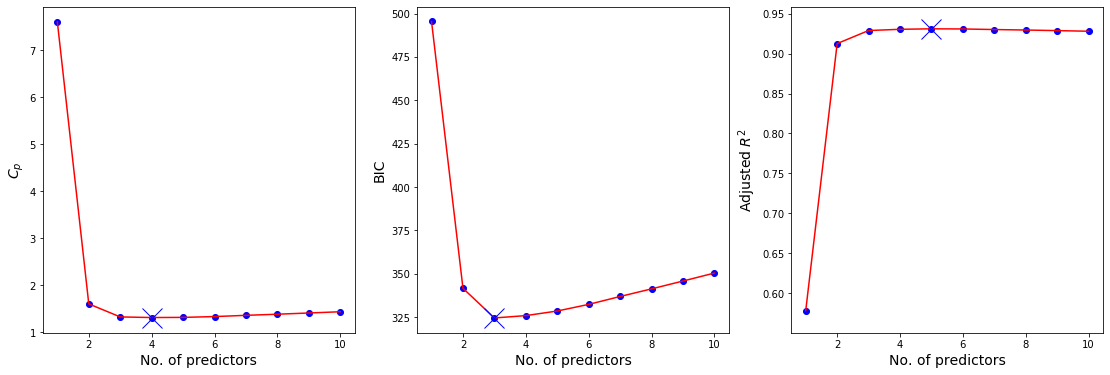

In [19]:
fig = plt.figure(figsize = (19,6))
ax1 = fig.add_subplot(131)
ax1.scatter(Eval_mat["Variable_count"], Eval_mat["Cp"], color = "b")
ax1.plot(Eval_mat["Variable_count"], Eval_mat["Cp"], color = "r")
ax1.plot(Eval_mat["Cp"].idxmin() + 1, Eval_mat["Cp"].min(), marker = "x", markersize = 20, color = 'b')
ax1.set_xlabel("No. of predictors", fontsize = 14)
ax1.set_ylabel("$C_p$", fontsize = 14)

ax2 = fig.add_subplot(132)
ax2.scatter(Eval_mat["Variable_count"], Eval_mat["BIC"], color = "b")
ax2.plot(Eval_mat["Variable_count"], Eval_mat["BIC"], color = "r")
ax2.plot(Eval_mat["BIC"].idxmin() + 1, Eval_mat["BIC"].min(), marker = "x", markersize = 20, color = 'b')
ax2.set_xlabel("No. of predictors", fontsize = 14)
ax2.set_ylabel("BIC", fontsize = 14)

ax3 = fig.add_subplot(133)
ax3.scatter(Eval_mat["Variable_count"], Eval_mat["Adjusted_R2"], color = "b")
ax3.plot(Eval_mat["Variable_count"], Eval_mat["Adjusted_R2"], color = "r")
ax3.plot(Eval_mat["Adjusted_R2"].idxmax() + 1, Eval_mat["Adjusted_R2"].max(), marker = "x", markersize = 20, color = 'b')
ax3.set_xlabel("No. of predictors", fontsize = 14)
ax3.set_ylabel("Adjusted $R^2$", fontsize = 14)

plt.show()

We can see that the variable selection based each of these metrices is quite different. BIC is selecting the model with smallest number of variables, while adjusted $R^2$ is selecting model with most number of variables. 

In [20]:
# 8.(d). # This function will return the best model with lowest BIC using Forward Selection method
def Forward_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    forward_sel = []
    var_left = variables.copy()
    BIC = []
    
    for k in range(len(variables)):
        RSS = []
        metric = []
        
        for p in range(len(var_left)):
            subset = forward_sel + [var_left[p]]
            all_columns = "+".join(subset)
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            RSS.append(model.mse_resid)
            metric.append(model.bic)
            
        forward_sel.append(var_left[RSS.index(min(RSS))])
        BIC.append(metric[RSS.index(min(RSS))])
            
        var_left = [x for x in variables if x not in forward_sel]
        print('Done for ', k)
        
    final_selection = forward_sel[:BIC.index(min(BIC))+1] # model with lowest BIC
    
    # Model for the final selection
    all_col = "+".join(final_selection)
    my_formula = response + '~' + all_col
    model = ols(formula = my_formula, data = dataset).fit()

    return model

FS_model = Forward_selection(poly_X,'Y')

Done for  0
Done for  1
Done for  2
Done for  3
Done for  4
Done for  5
Done for  6
Done for  7
Done for  8
Done for  9


In [21]:
FS_model.params

Intercept    3.062164
X2          -3.012660
X1           2.008797
X5           0.049532
dtype: float64

We can see that Forward selection we are selecting the same model as Best Subset Selection using BIC as selection criteria.

In [24]:
# This function will return the best model with lowest BIC using Backward Selection method
def Backward_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    backward_sel = []
    var_left = variables.copy()
    BIC = []
    
    for k in range(len(variables)):
        RSS = []
        metric = []
        if k == 0:
            subset = var_left
            all_columns = "+".join(subset)
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            
            backward_sel.append(var_left)
            BIC.append(model.bic)
        
        else:
            for p in range(len(var_left)):
                subset = [var_left[i] for i in range(len(var_left)) if i!= p]
                all_columns = "+".join(subset)
                my_formula = response + '~' + all_columns
                model = ols(formula = my_formula, data = dataset).fit()
                RSS.append(model.mse_resid)
                metric.append(model.bic)
            
            backward_sel.append([var_left[i] for i in range(len(var_left)) if i!= RSS.index(min(RSS))])
            BIC.append(metric[RSS.index(min(RSS))])
            
            var_left = np.delete(var_left, RSS.index(min(RSS)))
        
        print('Done for ', k)
        
    final_selection = backward_sel[BIC.index(min(BIC))] # model with lowest BIC
    
    # Model for the final selection
    all_col = "+".join(final_selection)
    my_formula = response + '~' + all_col
    model = ols(formula = my_formula, data = dataset).fit()

    return model

BS_model = Backward_selection(poly_X,'Y')

Done for  0
Done for  1
Done for  2
Done for  3
Done for  4
Done for  5
Done for  6
Done for  7
Done for  8
Done for  9


In [25]:
BS_model.params

Intercept    3.044636
X1           2.122237
X2          -2.992639
X7           0.008145
dtype: float64

We can see that Backward selection we are selecting the same model as Best Subset Selection using BIC as selection criteria.

In [38]:
# 8.(e). 
X = np.array(poly_X.drop('Y',axis = 1))
y = np.array(poly_X['Y'])
cv_Lasso = LassoCV(cv=5, random_state=0).fit(X , y)

/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16505458132792228, tolerance: 0.16036705737301962
  tol, rng, random, positive)
/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22061358378664409, tolerance: 0.16036705737301962
  tol, rng, random, positive)
/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25485279639997316, tolerance: 0.16036705737301962
  tol, rng, random, positive)
/Users/ankittyagi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.

In [40]:
print(cv_Lasso.coef_)
print(cv_Lasso.alpha_)

[ 0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.00238681 -0.00213065]
52.46647234525658


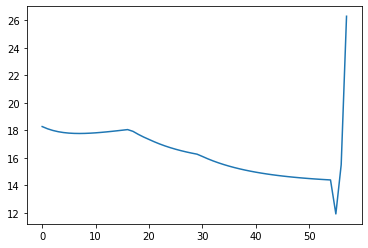

In [54]:
# Cross validation error plot
plt.plot(np.mean(cv_Lasso.mse_path_,axis = 1)[:58]) # Plotting the first 58 values of alpha
plt.show()

The plot above shows how the CV error decrease first and then start increasing after a certain value. The value of alpha with minimum CV error is 52.5.
Another thing is that the model selected by Lasso is completely different from the one selected with other methods.

In [66]:
# 9.(a). 
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/College.csv"
College = pd.read_csv(url, index_col = 0)
dummy = pd.get_dummies(College[['Private']]) # Creating dummies for categorical vars
College = pd.concat([College,dummy],axis = 1)

X = np.array(College.drop(['Apps','Private','Private_No'], axis = 1))
y = np.array(College['Apps'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=70)

In [67]:
# 9.(b).
lm = LinearRegression()
lm.fit(X_train,y_train)
np.mean((lm.predict(X_test) - y_test)**2) # Test Error

992060.7903898334

In [71]:
# 9.(c). 
# Ridge Regression 
lambda_range = np.linspace(1,500,500)

cv_ridge = RidgeCV(alphas = lambda_range, store_cv_values = True).fit(X_train,y_train)
cv_ridge.alpha_ 

500.0

In [77]:
np.mean((cv_ridge.predict(X_test) - y_test)**2) # Test Error

1016374.1159994911

In [78]:
# 9.(d).
cv_Lasso = LassoCV(cv=5, random_state=0).fit(X_train , y_train)
cv_Lasso.alpha_

45068.49302557086

In [79]:
np.mean((cv_Lasso.predict(X_test) - y_test)**2) # Test Error

1106872.2596497042

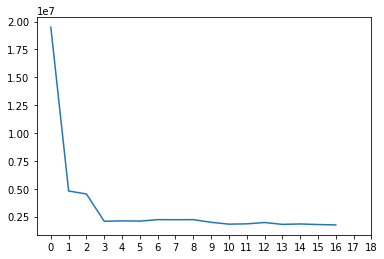

In [81]:
# 9.(e).
# Now we will fit the PCR on the training data and calculate the error 
mse = make_scorer(mean_squared_error)
def get_models():
    models = dict()
    for i in range(1,20):
        steps = [('pca',PCA(n_components = i)),('m',LinearRegression())]
        models[str(i)] = Pipeline(steps = steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
    scores = cross_val_score(model, X_train, y_train, scoring= mse, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
plt.plot(np.mean(results, axis = 1))
plt.xticks(list(range(0,19)))
plt.show()

In [86]:
# The above plot suggest M = 4 or M = 11.
# fit the PCA and transform the training and test dataset
X_train_PCA = models['11']['pca'].fit_transform(X_train)
X_test_PCA = models['11']['pca'].transform(X_test)

lm = LinearRegression()
lm.fit(X_train_PCA, y_train)
np.mean((lm.predict(X_test_PCA) - y_test)**2)

1080825.059546384

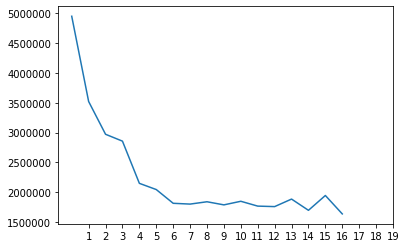

In [87]:
# 9.(f).
# evaluate a given model using cross-validation
def PLS_cv(X,y,n_comp):
    model = PLSRegression(n_components = n_comp)
    cv = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
    scores = cross_val_score(model, X, y, scoring= mse, cv=cv, n_jobs=-1)
    return scores

# evaluate the models and store results
results, names = list(), list()
for i in range(1,20):
    scores = PLS_cv(X_train,y_train,i)
    results.append(scores)
    names.append(i)    
    
plt.plot(np.mean(results, axis = 1))
plt.xticks(names)
plt.show()

In [91]:
# The chart above shows that M = 7 or M = 15
# fit the PCA and transform the training and test dataset
pls = PLSRegression(n_components =15)

X_train_PLS = pls.fit_transform(X_train, y_train)
X_train_PLS = X_train_PLS[0]

X_test_PLS = pls.transform(X_test)

lm = LinearRegression()
lm.fit(X_train_PLS, y_train)
np.mean((lm.predict(X_test_PLS) - y_test)**2)

990927.5386504993

We can see that there is not much difference in the results and least square has performed even better in some cases. Also, the error seems to be quite high in all the cases.

In [136]:
# 10.(a).
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Boston.csv"
Boston = pd.read_csv(url)
variables = Boston.columns
variables = variables.drop("crim")

In [138]:
def Best_subset_selection(dataset,response):
    variables = dataset.columns
    variables = variables.drop(response)
    results = []
    for k in range(len(variables)):
        for subset in itertools.combinations(variables,k+1):
            all_columns = "+".join(list(subset))
            
            my_formula = response + '~' + all_columns
            model = ols(formula = my_formula, data = dataset).fit()
            results.append({"RSS":model.mse_resid, "R_squared": model.rsquared,"Variable_count": k+1, 
                            'resid_sum': (model.resid ** 2).sum(), 'BIC': model.bic, 
                            'Adjusted_R2': model.rsquared_adj})
        print("Done for : ",k)
    Matrices = pd.DataFrame(results)
    return(Matrices)
Metrices = Best_subset_selection(Boston, "crim")

sigma_sq = Metrices[Metrices['Variable_count']== len(Boston.columns) -1]['resid_sum']/(len(Boston) - len(Boston.columns) -1)
Metrices["Cp"] = (Metrices['resid_sum'] + 2 * Metrices['Variable_count'] * sigma_sq.values)/len(Boston)

# Function to calculate the different statistics corresponding to each subset of varibles.
def BSS_metrices(matrix, data):    
    Min_RSS = matrix.groupby(["Variable_count"])['RSS'].min().reset_index()
    Max_R2 = matrix.groupby(["Variable_count"])['R_squared'].max().reset_index()
    Min_BIC = matrix.groupby(["Variable_count"])['BIC'].min().reset_index()
    Max_adj_R2 = matrix.groupby(["Variable_count"])['Adjusted_R2'].max().reset_index()
    sigma_sq = matrix[matrix['Variable_count']== len(data.columns) -1]['resid_sum']/(len(data) - len(data.columns) -1)
    Min_Cp = matrix.groupby(["Variable_count"])['Cp'].min().reset_index()
    All_mat = pd.concat([Min_RSS, Max_R2["R_squared"], Min_BIC["BIC"], Max_adj_R2["Adjusted_R2"], Min_Cp["Cp"]], axis = 1)
    return(All_mat)

Eval_mat = BSS_metrices(Metrices,Boston)

Done for :  0
Done for :  1
Done for :  2
Done for :  3
Done for :  4
Done for :  5
Done for :  6
Done for :  7
Done for :  8
Done for :  9
Done for :  10
Done for :  11
Done for :  12


In [139]:
# Function to get the list of variables that resulted in best statistics defined.
def get_best_param(Eval_mat, matrix, stats, dataset, response):
    variables = dataset.columns
    variables = variables.drop(response)
    if stats in ['RSS','BIC','Cp']:        
        no_var = (Eval_mat[Eval_mat[stats] == Eval_mat[stats].min()]["Variable_count"]).values[0]
        min_val = Eval_mat[stats].min()
        data = matrix[matrix['Variable_count'] == no_var]
        print(list(itertools.combinations(variables,no_var))[data[data[stats] == min_val].index[0] - data.index[0]])
    else:    
        no_var = (Eval_mat[Eval_mat[stats] == Eval_mat[stats].max()]["Variable_count"]).values[0]
        max_val = Eval_mat[stats].max()
        data = matrix[matrix['Variable_count'] == no_var]
        print(list(itertools.combinations(variables,no_var))[data[data[stats] == max_val].index[0] - data.index[0]])
        
get_best_param(Eval_mat, Metrices, 'BIC', Boston, 'crim')

('rad', 'black', 'lstat')


In [140]:
X = np.array(Boston.drop('crim',axis = 1))
y = np.array(Boston['crim'])
cv_Lasso = LassoCV(cv=5, random_state=0).fit(X , y)
cv_Lasso.coef_

array([ 0.02410063, -0.00477455, -0.        , -0.        ,  0.        ,
        0.01178236, -0.03409809,  0.49274523, -0.00078494, -0.        ,
       -0.00942876,  0.12270841, -0.08859749])

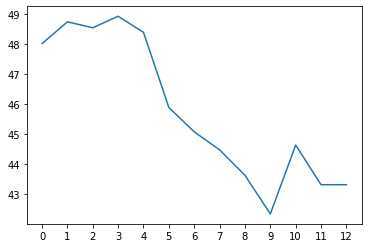

In [142]:
mse = make_scorer(mean_squared_error)
def get_models():
    models = dict()
    for i in range(1,20):
        steps = [('pca',PCA(n_components = i)),('m',LinearRegression())]
        models[str(i)] = Pipeline(steps = steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
    scores = cross_val_score(model, X, y, scoring= mse, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
plt.plot(np.mean(results, axis = 1))
plt.xticks(list(range(0,13)))
plt.show()

In [143]:
# The above plot suggest M = 4 or M = 11.
# fit the PCA and transform the training and test dataset
X_PCA = models['10']['pca'].fit_transform(X)

lm = LinearRegression()
lm.fit(X_PCA, y)
np.mean((lm.predict(X_PCA) - y)**2)

40.723084764790066